In [ ]:

%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path

root_path = Path().resolve().parent
sys.path.append(str(root_path))

from langgraph.graph import StateGraph, START

from typing import Literal

from tools.text_to_vis_tool import TextToVis, VisTool

from pydantic import BaseModel, Field

from langchain_core.prompts import ChatPromptTemplate
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

from prompt_visualization_builder.VannaPromptVisualizationBuilder import (
    VannaPromptVisualizationBuilder,
)
from langchain_core.messages import HumanMessage
from functions.gptconfig import MODEL_4O, MODEL_35_TURBO, MODEL_O3_MINI
from functions.langchain_utils import get_llm

load_dotenv()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [120]:
BASE_DIR = Path().resolve().parent
PARENT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
DATASETS_DIR = BASE_DIR / "datasets"

In [121]:
MODELS = [MODEL_4O, MODEL_35_TURBO, MODEL_O3_MINI]

model = MODEL_4O

## Datasets

In [122]:
movies_dataset = pd.read_csv(f"{DATASETS_DIR}/movies.csv")

In [123]:
movies_dataset.head(3)

,Title,Worldwide Gross,Production Budget,Release Year,Content Rating,Running Time,Genre,Creative Type,Rotten Tomatoes Rating,IMDB Rating
0,From Dusk Till Dawn,25728961,20000000,1996,R,107,Horror,Fantasy,63,7.1
1,Broken Arrow,148345997,65000000,1996,R,108,Action,Contemporary Fiction,55,5.8
2,City Hall,20278055,40000000,1996,R,111,Drama,Contemporary Fiction,55,6.1


## Tools

In [ ]:
prompt_builder_vanna = VannaPromptVisualizationBuilder()
text_to_vis_vanna = TextToVis(
    llm=get_llm(model=model),
    prompt_builder=prompt_builder_vanna,
    model_type=model
)


In [ ]:

vanna_vis_tool = VisTool() 

if hasattr(vanna_vis_tool, "text_to_vis"):
    vanna_vis_tool.text_to_vis = text_to_vis_vanna
    

TOOLS = [vanna_vis_tool]

In [ ]:

print(vanna_vis_tool.text_to_vis.prompt_builder)

vanna


In [ ]:

VIS_STRATEGIES = [str(vanna_vis_tool.text_to_vis.prompt_builder)]
VIS_STRATEGIES

['vanna']

## Tools test

In [15]:
result2 = vanna_vis_tool._run("number movies Released by Year", movies_dataset)

------------------------------
Vanna Visualization Strategy


In [16]:
print(result2.get("code_generated"))

import streamlit as st
import pandas as pd
df = df.copy()
import plotly.express as px
import streamlit as st
import pandas as pd
df = df.copy()

if df['Release Year'].nunique() == 1:
    single_value = df['Release Year'].iloc[0]
    fig = px.indicator.Indicator(
        mode="number",
        value=single_value,
        title="Number of Movies Released in the Year"
    )
else:
    year_counts = df['Release Year'].value_counts().reset_index()
    year_counts.columns = ['Release Year', 'Number of Movies']
    year_counts = year_counts.sort_values('Release Year')
    fig = px.bar(
        year_counts,
        x='Release Year',
        y='Number of Movies',
        title='Number of Movies Released by Year',
        labels={'Release Year': 'Year', 'Number of Movies': 'Movies Released'}
    )

st.plotly_chart(fig)


In [17]:
result2.get("fig")

## Question Clarifier

In [148]:

class ClarifiedQuery(BaseModel):
    """Clarify the user's query."""
    clarified_question: str = Field(
        description="The user query clarified",
    )
    final_decision: Literal["yes", "no"] = Field (
        description="If the query is clear, put \"yes\", if not, put \"no\""
    )
 
    
llm = get_llm(model=MODEL_4O, temperature=0)

structured_llm_clarifier = llm.with_structured_output(ClarifiedQuery)

with open('../prompts/question_clarifier_prompt.txt', 'r') as file:
    system = file.read()      

clarify_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "the user's question: {question}"),
    ]
)

question_clarifier = clarify_prompt | structured_llm_clarifier

In [19]:
question_clarifier.invoke({"question": "What is this?"})

ClarifiedQuery(clarified_question="Your question is unclear. Could you specify what 'this' refers to? Are you asking about a specific dataset, metric, or context?", final_decision='no')

In [20]:
question_clarifier.invoke({"question": "What is the capital of Cuba?"})

ClarifiedQuery(clarified_question='What is the capital city of Cuba?', final_decision='yes')

## Data StoryTelling

In [ ]:
class DataStorytelling(BaseModel):
    task: str = Field(..., description="Type of analysis task being performed, e.g., 'data_storytelling', 'trend_explanation'.")
    narrative: str = Field(..., description="Complete analysis including titles, sections, and narrative text.")
    
def show_data_storytelling(dataStorytelling: DataStorytelling):
    """Display the markdown narrative."""
    from IPython.display import Markdown, display
    display(Markdown(dataStorytelling.narrative))
    

llm = get_llm(model=MODEL_4O, max_tokens=1000, temperature=0)

structured_llm_data_storytelling = llm.with_structured_output(DataStorytelling)

with open('../prompts/data_storytelling_prompt.txt', 'r', encoding="utf-8") as file:
    data_storytelling_system = file.read()      
# print(data_storytelling_system)
data_storytelling_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", data_storytelling_system),
        ("human", "User Input: {question}\n\nPython Code Used:\n{code}\nChart Generated:\n{chart}"),
    ]
)

data_storytelling = data_storytelling_prompt | structured_llm_data_storytelling
    

In [96]:
show_data_storytelling(result)

## The Evolution of Movie Releases Over Time

### Context: A Changing Industry
The film industry has always been a reflection of cultural, technological, and economic shifts. By examining the number of movies released each year, we can uncover patterns that reveal how the industry has evolved over time.

### The Challenge: A Sudden Decline
From 1996 to 2010, the number of movies released annually showed a mix of growth and fluctuation. However, a striking anomaly emerges in the data: after a relatively stable period of releases, there is a sharp and dramatic drop in 2010, with only 5 movies released that year. This is a stark contrast to the preceding years, where releases ranged between 34 and 65 movies annually.

### Insights from the Data
- **Steady Growth and Fluctuations:** Between 1996 and 2009, the number of movies released each year fluctuated but remained within a consistent range, peaking at 65 movies in 2000.
- **The 2010 Collapse:** The sudden drop to just 5 movies in 2010 is an outlier that demands further investigation. Possible explanations could include economic downturns, shifts in production strategies, or external disruptions like strikes or global events.

### What This Means
This data tells a story of resilience and growth in the film industry, punctuated by a dramatic and unexplained decline. Understanding the factors behind this drop could provide valuable lessons for navigating future challenges in the industry. Was it a one-time event, or does it signal a deeper trend? Further exploration is needed to uncover the full story.

# Graph

## State

In [ ]:
from typing_extensions import TypedDict
import pandas as pd

class State(TypedDict):
    """
    Represents the state of the graph.

    Attributes:
        question: user query
        clarify_decision: final decision of clarifier
        clarified_question: user query clarified
        dataset: the dataset containing the database result
        code: dict containig the code and metadata generated by text to visualization  strategies
        best_vis_strategy:  containig the best text to visualization strategy chosen by llm
        narrative: the narrative generated by llm based on the chart, code and question
    """

    question: str
    clarifier_decision: str
    clarified_question: str
    dataset: pd.DataFrame       
    codes: dict
    best_vis_strategy: str
    narrative: str

## Nodes

In [ ]:


def clarify_question(state: State) -> State:
    resp = question_clarifier.invoke({"question": state['question']})
    clarifier_decision = f"Final Decision: {resp.final_decision} - {resp.clarified_question}"
    print("[Clarifier Decision] "+ clarifier_decision)
    if resp.final_decision=="yes":
        return {**state, "clarified_question": resp.clarified_question, "clarifier_decision": resp.final_decision}
    else:
        old_question = "Old Question: " + state["question"]
        clarifier_decision = "Agent Feedback: " + resp.clarified_question
        agent_feedback = f"{old_question}\n{clarifier_decision}"
    
    return {**state, "question": agent_feedback, "clarifier_decision": resp.final_decision}

def ask_human_clarify(state: State) -> State:
    q = state["question"]
    print("[NODE] Feedback human")
    human_response = interrupt(f"Please clarify your question: \"{q}\"")
    new_information += "\nHuman Feedback:{human_response}"
    return {**state, "question": new_information}

def node_vis(state: State) -> State:
    print("[Text-to-VIS] - Query:" + state["clarified_question"])
    dataset = state["dataset"]
    vis_tools = TOOLS[0:]
    codes = {}
    for vis_tool in vis_tools:
        
        code = vis_tool._run(
            question=state["clarified_question"],
            df=dataset
        )
        codes[str(vis_tool.text_to_vis.prompt_builder)] = code
    return {**state, "codes": codes}
    
def data_storyteller(state: State) -> State:
    print("[Data Storytelling] - Generating narrative")
    state["best_vis_strategy"] = 'vanna'
    question = state["clarified_question"]
    code = state["codes"][state["best_vis_strategy"]].get("code_generated")
    chart = str(state["codes"][state["best_vis_strategy"]].get("fig").layout) + "\n" + str(state["codes"][state["best_vis_strategy"]].get("fig").data)
    # print("[Data Storytelling] - Question: " + question)
    # print("[Data Storytelling] - Code: " + code)
    # print("[Data Storytelling] - Chart: " + str(chart))
    result = data_storytelling.invoke({"question": question, "code": code, "chart": chart})
    show_data_storytelling(result)
    return {**state, "narrative": result}

### clarify question node test

In [26]:
agent_input = {
    "question":"What is capital of cuba?",
}
clarify_question(agent_input)

[Clarifier Decision] Final Decision: yes - What is the capital city of Cuba?


{'question': 'What is capital of cuba?',
 'clarified_question': 'What is the capital city of Cuba?',
 'clarifier_decision': 'yes'}

In [27]:
agent_input = {
    "question":"What is this?",
}
clarify_question(agent_input)

[Clarifier Decision] Final Decision: no - The question is too vague. Could you specify what you are referring to? For example, are you asking about a specific dataset, metric, or report?


{'question': 'Old Question: What is this?\nAgent Feedback: The question is too vague. Could you specify what you are referring to? For example, are you asking about a specific dataset, metric, or report?',
 'clarifier_decision': 'no'}

In [28]:
question_with_feedback = f"Old Question: What is this?\nAgent FeedbackYour question is unclear. Could you specify what 'this' refers to? Are you asking about a specific dataset, metric, or something else\nHuman Feedback:Capital of japan"

agent_input = {
    "question":question_with_feedback,
}
clarify_question(agent_input)

[Clarifier Decision] Final Decision: yes - What is the capital of Japan?


{'question': "Old Question: What is this?\nAgent FeedbackYour question is unclear. Could you specify what 'this' refers to? Are you asking about a specific dataset, metric, or something else\nHuman Feedback:Capital of japan",
 'clarified_question': 'What is the capital of Japan?',
 'clarifier_decision': 'yes'}

## Router

In [169]:
def router(state: State) -> Literal["clarify", "text_to_vis", "__end__"]:
    decision = "__end__"
    if "clarified_question" not in state:
        decision = "clarify"
        if "clarifier_decision" in state and state["clarifier_decision"] == "no":
            decision = "ask_human_clarify"
    elif "code" not in state:
        decision = "text_to_vis"
    elif "narrative" not in state:
        decision = "data_storyteller"
    print("[Router] Decision: " + decision)
    return decision


## Build Graph

In [ ]:

def build_graph() -> StateGraph:
    
    graph_builder = StateGraph(State)
    graph_builder.add_node("Clarify Question\n*LLM as Judge*", clarify_question)
    graph_builder.add_node("Text-to-VIS", node_vis)
    graph_builder.add_node("Human Feedback", ask_human_clarify)
    graph_builder.add_node("Data Storyteller\n*LLM as Narrator*", data_storyteller)
      
    graph_builder.add_conditional_edges(
        "Clarify Question\n*LLM as Judge*", 
        router, 
        {
            "text_to_vis": "Text-to-VIS",
            "ask_human_clarify": "Human Feedback",
        }
    )
    
    graph_builder.add_edge(
        "Human Feedback", 
        "Clarify Question\n*LLM as Judge*"
    )
        
    graph_builder.add_edge(
        "Text-to-VIS", 
        "Data Storyteller\n*LLM as Narrator*"
    )
        
    graph_builder.add_edge(
        "Data Storyteller\n*LLM as Narrator*", 
        "__end__"
    )
        
    graph_builder.add_edge(START, "Clarify Question\n*LLM as Judge*")
    
    return graph_builder.compile()

graph = build_graph()

def send(agent_input: State) -> State:
    """
    This function is used to get the response from the agent.
    """
    return graph.invoke(agent_input)

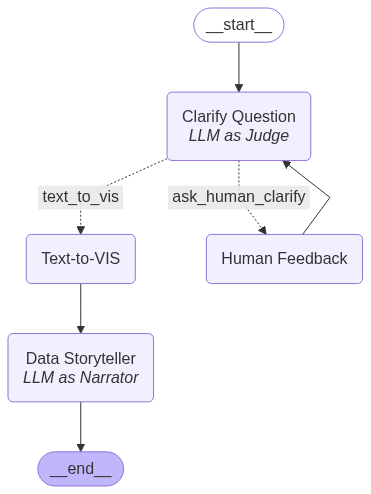

In [171]:
from IPython.display import Image, display


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [172]:
def run_experiment(question, dataset):
    agent_input = {
        "question":question,
        "dataset": dataset
    }
    while True:  
        graph_result = send(agent_input)

        if graph_result["clarifier_decision"] == "yes":
            break
        else:
            user_feedback = input(graph_result["question"])
            graph_result["question"] += user_feedback 
            graph_result["clarifier_decision"] = ""
            agent_input = graph_result
    return graph_result

## Experiments


#### Case Study 1

In [175]:
graph_result = run_experiment(question = " number of movies released by year.", dataset=movies_dataset)

[Clarifier Decision] Final Decision: yes - How many movies were released each year, grouped by year?
[Router] Decision: text_to_vis
[Text-to-VIS] - Query:How many movies were released each year, grouped by year?
------------------------------
Vanna Visualization Strategy
[Data Storytelling] - Generating narrative


## The Evolution of Movie Releases Over Time

### Context: A Changing Film Industry
The film industry is a dynamic space, constantly influenced by technological advancements, audience preferences, and global events. Understanding how the number of movies released each year has changed can provide insights into broader industry trends and challenges.

### Conflict: A Noticeable Decline in Recent Years
The data reveals a fluctuating trend in movie releases from 1996 to 2010. While the late 1990s and early 2000s saw a steady increase in the number of movies released annually, peaking around 2000 with 65 films, the years following 2007 show a sharp decline. By 2010, the number of movies released plummeted to just 5—a dramatic drop that raises questions about what might have caused such a downturn.

### Insights from the Data
- **Growth Period (1996-2000):** The late 1990s experienced a consistent rise in movie releases, reflecting perhaps a booming industry or increased accessibility to filmmaking resources.
- **Stability and Fluctuations (2001-2007):** The early 2000s maintained relatively stable numbers, with minor fluctuations, suggesting a period of consolidation in the industry.
- **Sharp Decline (2008-2010):** The most striking trend is the steep drop in movie releases after 2007, culminating in an almost negligible output by 2010.

### Hypotheses for the Decline
- **Economic Factors:** The global financial crisis of 2008 may have severely impacted film production budgets and investments.
- **Technological Shifts:** The rise of digital streaming platforms during this period could have disrupted traditional movie production and distribution models.
- **Industry Saturation:** A potential oversaturation of the market in earlier years might have led to a pullback in production.

### Conclusion: A Call for Further Exploration
This data tells a story of growth, stability, and eventual decline in movie releases over a 15-year period. The sharp drop in the late 2000s warrants deeper investigation into the economic, technological, and cultural factors at play. Understanding these shifts can help industry stakeholders adapt and innovate for future growth.

Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py", line 716, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\rogerrsn\AppData\Local\Pro

In [106]:
graph_result.get("best_vis_strategy")

'vanna'

In [107]:
graph_result.get("codes")[graph_result.get("best_vis_strategy")].get("fig")

#### Case Study 2

In [176]:
graph_result = run_experiment(question = "Which movie genres have the highest average gross income?", dataset=movies_dataset)

[Clarifier Decision] Final Decision: yes - Which movie genres have the highest average gross income across all time?
[Router] Decision: text_to_vis
[Text-to-VIS] - Query:Which movie genres have the highest average gross income across all time?
------------------------------
Vanna Visualization Strategy
[Data Storytelling] - Generating narrative


## The Power of Genre in Box Office Success

### Context: The Movie Industry's Quest for Profit
The film industry is a high-stakes game where studios invest millions in hopes of blockbuster returns. But not all genres are created equal when it comes to raking in revenue. Understanding which genres consistently generate the highest average gross income can guide studios in making strategic decisions about future projects.

### Conflict: The Uneven Playing Field of Genres
The data reveals a stark disparity in the earning potential of different movie genres. While some genres dominate the box office, others struggle to achieve comparable financial success. This raises questions about audience preferences and the factors driving these trends.

### Data Insights: The Winners and Losers
- **Adventure films** emerge as the undisputed champions, boasting the highest average gross income. Their ability to transport audiences to fantastical worlds and deliver high-stakes narratives likely contributes to their widespread appeal.
- **Action movies** follow closely, leveraging adrenaline-pumping sequences and star power to draw massive crowds.
- **Musicals** and **romantic comedies** also perform well, suggesting a strong audience appetite for feel-good, emotionally engaging content.
- At the other end of the spectrum, genres like **black comedy**, **concert films**, and **westerns** struggle to achieve similar financial success, indicating niche appeal or limited audience reach.

### Insight: Why Adventure Reigns Supreme
Adventure films often combine elements of action, drama, and fantasy, appealing to a broad demographic. Their high production values and global marketing campaigns make them a safe bet for studios aiming for blockbuster status.

### Conclusion: Strategic Implications for Studios
For studios aiming to maximize revenue, investing in adventure and action films appears to be a winning strategy. However, the success of musicals and romantic comedies suggests that diversifying into emotionally resonant genres can also yield significant returns. Understanding audience preferences and market trends will be key to navigating the ever-evolving landscape of the film industry.

Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py", line 716, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\rogerrsn\AppData\Local\Pro

In [164]:
graph_result.get("best_vis_strategy")

'vanna'

In [116]:
graph_result.get("codes")[graph_result.get("best_vis_strategy")].get("fig")

#### Case Study 3

In [177]:
graph_result = run_experiment(question =  "Is there a relationship between movie budget and gross income?", dataset=movies_dataset)

[Clarifier Decision] Final Decision: no - Do you want to analyze the correlation between movie budgets and gross income for all movies in the database, or for a specific time period or genre?
[Router] Decision: ask_human_clarify
[NODE] Feedback human
[Clarifier Decision] Final Decision: no - Do you want to analyze the correlation between movie budgets and gross income for all movies in the database, or for a specific time period or genre?
[Router] Decision: ask_human_clarify
[NODE] Feedback human
[Clarifier Decision] Final Decision: yes - Analyze the correlation between movie budgets and gross income for movies in the adventure genre.
[Router] Decision: text_to_vis
[Text-to-VIS] - Query:Analyze the correlation between movie budgets and gross income for movies in the adventure genre.
------------------------------
Vanna Visualization Strategy
[Data Storytelling] - Generating narrative


## The Relationship Between Adventure Movie Budgets and Box Office Success

### Context: The High-Stakes World of Adventure Films
Adventure movies are known for their grand scale, breathtaking visuals, and often hefty production budgets. But does spending more on production guarantee a blockbuster hit? This analysis explores the relationship between production budgets and worldwide gross income for adventure films, shedding light on whether bigger budgets translate to bigger box office returns.

### The Challenge: The Budget vs. Revenue Dilemma
While it’s tempting to assume that higher budgets lead to higher earnings, the data reveals a more nuanced story. The scatterplot shows a positive correlation between production budgets and worldwide gross income, but the relationship is far from linear. Some high-budget films achieve astronomical success, while others fail to recoup their costs. Similarly, a few lower-budget films manage to punch above their weight, earning impressive returns.

### Key Insights from the Data:
- **Positive Correlation with Variability:** Generally, as production budgets increase, so does the worldwide gross. However, the spread of data points indicates significant variability in outcomes, even among films with similar budgets.
- **Outliers and Blockbusters:** Films like *Spider-Man 3* and *Pirates of the Caribbean: Dead Man's Chest* stand out as high-budget productions that delivered massive box office returns, reinforcing the idea that some investments do pay off spectacularly.
- **The Risk of High Budgets:** Not all high-budget films are guaranteed hits. For instance, some movies with budgets exceeding $150 million failed to break even, highlighting the financial risks involved.
- **Surprising Success Stories:** A few lower-budget films, such as *Shrek* and *Finding Nemo*, achieved remarkable success, proving that creativity and storytelling can sometimes outweigh sheer financial investment.

### Conclusion: Balancing Art and Commerce
The data underscores the high-risk, high-reward nature of the adventure genre. While larger budgets often lead to higher earnings, they also come with greater financial risk. Filmmakers and studios must strike a delicate balance between investing in production quality and ensuring a compelling story that resonates with audiences. Ultimately, the magic of cinema lies not just in the money spent but in the ability to captivate and inspire viewers.

Exception while exporting Span.
Traceback (most recent call last):
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\rogerrsn\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py", line 716, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\rogerrsn\AppData\Local\Pro

In [178]:
graph_result.get("best_vis_strategy")

'vanna'

In [179]:
graph_result.get("codes")[graph_result.get("best_vis_strategy")].get("fig")